In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize
from dataclasses import dataclass, field

In [118]:
# List of years to process
years = [2020, 2021, 2022, 2023, 2024]

# Load and combine the CSV files
df = []
for year in years:
    url = f"https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv"
    df.append(pd.read_csv(url))
df = pd.concat(df)

In [121]:
df = df.query('tourney_level == "G"')

In [122]:
# Select minimal columns for win/loss analysis
columns_to_keep = [
    'tourney_id',       # Unique tournament identifier
    'tourney_date',     # Date of the tournament (for ordering)
    'match_num',        # Match number within tournament (for finer ordering)
    'winner_id',        # Unique ID of the winner
    'winner_name',      # Name of the winner (for readability)
    'loser_id',         # Unique ID of the loser
    'loser_name',       # Name of the loser (for readability)
    'winner_rank',      # Winner's rank (optional, for validation)
    'loser_rank'        # Loser's rank (optional, for validation)
]

In [123]:
df = df[columns_to_keep]

In [124]:
# Convert tourney_date to datetime
df.loc[:, 'tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')

/var/folders/1h/y7css5mj58d0d43d5rmmv58m0000gp/T/ipykernel_52311/1502293871.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2020-01-20 00:00:00', '2020-01-20 00:00:00', '2020-01-20 00:00:00',
 '2020-01-20 00:00:00', '2020-01-20 00:00:00', '2020-01-20 00:00:00',
 '2020-01-20 00:00:00', '2020-01-20 00:00:00', '2020-01-20 00:00:00',
 '2020-01-20 00:00:00',
 ...
 '2024-08-26 00:00:00', '2024-08-26 00:00:00', '2024-08-26 00:00:00',
 '2024-08-26 00:00:00', '2024-08-26 00:00:00', '2024-08-26 00:00:00',
 '2024-08-26 00:00:00', '2024-08-26 00:00:00', '2024-08-26 00:00:00',
 '2024-08-26 00:00:00']
Length: 2413, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')


In [125]:
# Handle missing values
df.loc[:, 'winner_rank'] = df['winner_rank'].fillna(-1).astype(int)
df.loc[:, 'loser_rank'] = df['loser_rank'].fillna(-1).astype(int)

In [126]:
df = df.sort_values(['tourney_date', 'match_num'])

In [127]:
# Rename columns for clarity
df.columns = [
    'tournament_id', 'match_date', 'match_number',
    'winner_id', 'winner_name', 'loser_id', 'loser_name',
    'winner_rank', 'loser_rank'
]

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2413 entries, 167 to 2313
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tournament_id  2413 non-null   object        
 1   match_date     2413 non-null   datetime64[ns]
 2   match_number   2413 non-null   int64         
 3   winner_id      2413 non-null   int64         
 4   winner_name    2413 non-null   object        
 5   loser_id       2413 non-null   int64         
 6   loser_name     2413 non-null   object        
 7   winner_rank    2413 non-null   float64       
 8   loser_rank     2413 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 188.5+ KB


In [129]:
df.to_csv('atp_matches_2020_2024_preprocessed.csv', index=False)

### Questions:

-  Is rank correlate well with win / loss ? 
-  Is rank difference has an impact on the probability of win/loss ?

### Model Setup

1. Each player $i$ has an underlying skill level $s_i$.
2. The probability that player $A$ beats player $B$ is modeled as:

$$
P(A \text { beats } B)=\Phi\left(\frac{s_A-s_B}{\sqrt{2} \beta}\right)
$$

where:
- $\Delta_{A B}=s_A-s_B=$ skill gap.
- $\beta$ is a scale parameter controlling the variance of the skill differences.
- $\Phi(z)$ is the cumulative distribution function (CDF) of the standard normal distribution:

$$
\Phi(z)=\int_{-\infty}^z \frac{1}{\sqrt{2 \pi}} e^{-\frac{u^2}{2}} d u
$$

***Q1: What using cumulative distribution function (CDF) ? Is any monotonic transform ok***


✅ Why use a cumulative distribution function (CDF)?
The Bradley-Terry model (or Thurstone-Mosteller model) is based on the idea that the probability of a player winning is a function of the difference in their latent skill levels.

The CDF of a probability distribution has desirable properties for this type of model:

**Monotonicity**

A CDF is a monotonically increasing function — larger differences in skill should correspond to higher probabilities of winning, which is exactly what we expect intuitively.

**Bounded in [0, 1]**

A CDF always produces output in the range [0, 1], which makes it naturally suited for modeling probabilities.

**Interpretability**

The use of the CDF implies that the skill differences follow some underlying probabilistic structure (e.g., normally distributed noise or variation in performance).

### Likelihood Function

Suppose we have a dataset of paired match outcomes:
- $y_{i j}=1$ if player $i$ beats player $j$
- $y_{i j}=0$ if player $j$ beats player $i$
The likelihood of observing the full dataset is:

$$
L(s, \beta)=\prod_{(i, j) \in \text { matches }} \Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)^{y_{i j}} \cdot\left(1-\Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)\right)^{1-y_{i j}}
$$


Taking the log-likelihood:

$$
\log L(s, \beta)=\sum_{(i, j) \in \text { matches }} y_{i j} \log \Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)+\left(1-y_{i j}\right) \log \left(1-\Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)\right)
$$



In [130]:
# Step 2: Improved Bradley-Terry Model
@dataclass
class BradleyTerryModel:
    n_players: int
    beta: float = 1.0
    reg_strength: float = 0.01
    skills: np.ndarray = field(init=False)

    def __post_init__(self):
        """Initialize skills with small random values."""
        self.skills = np.random.normal(0, 0.1, self.n_players)

    def _log_likelihood(self, params, matches, outcomes):
        """Compute negative log-likelihood with L2 regularization."""
        skills = params[:-1]
        beta = np.exp(params[-1])

        skill_diff = skills[matches[:, 0]] - skills[matches[:, 1]]
        prob = 1 / (1 + np.exp(-skill_diff / beta))
        prob = np.clip(prob, 1e-10, 1 - 1e-10)

        log_likelihood = outcomes * np.log(prob) + (1 - outcomes) * np.log(1 - prob)
        reg_term = self.reg_strength * np.sum(skills ** 2)
        return -np.sum(log_likelihood) + reg_term

    def _callback(self, params):
        """Callback to monitor optimization progress."""
        skills = params[:-1]
        beta = np.exp(params[-1])
        obj_value = self._log_likelihood(params, self.matches, self.outcomes)
        print(f"Current objective: {obj_value:.4f}, Beta: {beta:.4f}, Skill range: {skills.min():.4f} to {skills.max():.4f}")

    def fit(self, matches, outcomes):
        """Fit the model with MLE and improved optimization."""
        self.matches = matches  # Store for callback
        self.outcomes = outcomes
        init_params = np.concatenate([self.skills, [np.log(self.beta)]])

        # Bounds: wider skill range, constrained beta
        bounds = [(-50, 50)] * self.n_players + [(np.log(0.1), np.log(5))]

        result = minimize(
            self._log_likelihood,
            init_params,
            args=(matches, outcomes),
            method='L-BFGS-B',
            bounds=bounds,
            callback=self._callback,  # Monitor progress
            options={
                'disp': True,
                'maxiter': 20000,
                'maxfun': 500000,  # Increase max function evaluations
                'gtol': 1e-5,     # Relaxed gradient tolerance
                'ftol': 1e-5      # Relaxed function tolerance
            }
        )

        if result.success:
            print(f"Optimization succeeded! Iterations: {result.nit}, Evaluations: {result.nfev}")
            print(f"Final beta: {np.exp(result.x[-1]):.4f}")
            self.skills = result.x[:-1]
            self.beta = np.exp(result.x[-1])
            self.skills -= self.skills.mean()  # Center skills
            print(f"Skill range: {self.skills.min():.4f} to {self.skills.max():.4f}")
            print(f"Skill variance: {np.var(self.skills):.4f}")
            print(f"First 10 skills: {self.skills[:10]}")
            if np.allclose(self.skills, self.skills[0], atol=1e-5):
                print("WARNING: Skills appear to have collapsed to a single value!")
        else:
            raise RuntimeError(f"Optimization failed: {result.message}")

        return result

    def predict_prob(self, i, j):
        """Predict probability that player i beats player j."""
        skill_diff = self.skills[i] - self.skills[j]
        return 1 / (1 + np.exp(-skill_diff / self.beta))

In [131]:

matches_minimal = df.copy()

# Map player IDs to 0 ... N for active players only
active_players = np.unique(np.concatenate([matches_minimal['winner_id'], matches_minimal['loser_id']]))
player_id_map = {old_id: new_id for new_id, old_id in enumerate(active_players)}
reverse_player_id_map = {new_id: old_id for old_id, new_id in player_id_map.items()}  # For mapping back
matches_minimal['winner_idx'] = matches_minimal['winner_id'].map(player_id_map)
matches_minimal['loser_idx'] = matches_minimal['loser_id'].map(player_id_map)

# Use only forward matches (no symmetry)
matches_array = np.array(matches_minimal[['winner_idx', 'loser_idx']])
outcomes_array = np.ones(len(matches_minimal), dtype=int)  # All outcomes are 1 (wins)

# Create a player name lookup
player_names = {}
for _, row in matches_minimal.iterrows():
    player_names[row['winner_id']] = row['winner_name']
    player_names[row['loser_id']] = row['loser_name']

In [132]:
player_names

{104745: 'Rafael Nadal',
 106198: 'Hugo Dellien',
 105643: 'Federico Delbonis',
 105311: 'Joao Sousa',
 105376: 'Peter Gojowczyk',
 111153: 'Christopher Eubanks',
 105807: 'Pablo Carreno Busta',
 106075: 'Jozef Kovalik',
 106401: 'Nick Kyrgios',
 132283: 'Lorenzo Sonego',
 104468: 'Gilles Simon',
 104655: 'Pablo Cuevas',
 144707: 'Mikael Ymer',
 106034: 'Yasutaka Uchiyama',
 111575: 'Karen Khachanov',
 106408: 'Mario Vilella Martinez',
 104792: 'Gael Monfils',
 104229: 'Yen Hsun Lu',
 103333: 'Ivo Karlovic',
 105577: 'Vasek Pospisil',
 105379: 'Aljaz Bedene',
 105902: 'James Duckworth',
 105208: 'Ernests Gulbis',
 200000: 'Felix Auger Aliassime',
 126203: 'Taylor Fritz',
 134868: 'Tallon Griekspoor',
 104731: 'Kevin Anderson',
 125802: 'Ilya Ivashka',
 106109: 'Alex Bolt',
 105077: 'Albert Ramos',
 106233: 'Dominic Thiem',
 105173: 'Adrian Mannarino',
 106421: 'Daniil Medvedev',
 126207: 'Frances Tiafoe',
 124079: 'Pedro Martinez',
 136440: 'Dominik Koepfer',
 144719: 'Jaume Munar',
 2

In [133]:
# Sanity check Example usage:
n_players = 5
matches = np.array([[0, 1], [2, 3], [0, 2], [3, 1], [4, 0]])
outcomes = np.array([1, 0, 1, 1, 0])  # player[i] wins over player[j]


In [134]:
model = BradleyTerryModel(n_players)
model.fit(matches, outcomes)

Current objective: 0.8412, Beta: 1.2325, Skill range: -1.0035 to 1.5254
Current objective: 0.1412, Beta: 0.3722, Skill range: -1.6004 to 2.3760
Current objective: 0.1076, Beta: 0.4253, Skill range: -1.3638 to 2.0279
Current objective: 0.0961, Beta: 0.4524, Skill range: -1.1934 to 1.7677
Current objective: 0.0877, Beta: 0.4312, Skill range: -1.1095 to 1.6315
Current objective: 0.0508, Beta: 0.2286, Skill range: -0.4710 to 0.7816
Current objective: 0.0299, Beta: 0.2034, Skill range: -0.6291 to 0.9664
Current objective: 0.0200, Beta: 0.1558, Skill range: -0.5123 to 0.7518
Current objective: 0.0139, Beta: 0.1287, Skill range: -0.4048 to 0.6392
Current objective: 0.0130, Beta: 0.1201, Skill range: -0.3559 to 0.5201
Current objective: 0.0103, Beta: 0.1000, Skill range: -0.2876 to 0.4559
Current objective: 0.0092, Beta: 0.1000, Skill range: -0.3413 to 0.4970
Current objective: 0.0092, Beta: 0.1000, Skill range: -0.3398 to 0.4983
Current objective: 0.0092, Beta: 0.1000, Skill range: -0.3373 to

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.009190207790338852
        x: [ 4.975e-01 -3.373e-01 -3.375e-01  4.355e-01 -2.582e-01
            -2.303e+00]
      nit: 14
      jac: [ 7.241e-07  2.946e-05  1.240e-05 -8.653e-05  6.104e-05
             1.470e-02]
     nfev: 133
     njev: 19
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [138]:
n_players = len(active_players)
model = BradleyTerryModel(n_players=n_players, beta=1.0, reg_strength=1e-4)
result = model.fit(matches_array, outcomes_array)

print("\nExample predictions:")
for i, j in matches_array[:5]:
    prob = model.predict_prob(i, j)
    print(f"Player {i} vs Player {j}: {prob:.4f}")


Current objective: 1407.9125, Beta: 5.0000, Skill range: -7.0899 to 49.1111
Current objective: 1351.3021, Beta: 5.0000, Skill range: -5.9415 to 41.2072
Current objective: 1307.3829, Beta: 5.0000, Skill range: -4.5217 to 31.4337
Current objective: 1302.5193, Beta: 5.0000, Skill range: -3.5565 to 24.7829
Current objective: 1290.6059, Beta: 4.1579, Skill range: -3.2453 to 22.6447
Current objective: 1272.6146, Beta: 2.8743, Skill range: -2.5592 to 16.3937
Current objective: 1259.9070, Beta: 2.0986, Skill range: -2.4277 to 14.9928
Current objective: 1257.3012, Beta: 1.8445, Skill range: -2.2322 to 13.0202
Current objective: 1231.6899, Beta: 1.2289, Skill range: -2.0531 to 6.2306
Current objective: 1205.4619, Beta: 1.3065, Skill range: -2.6658 to 6.1389
Current objective: 1197.4648, Beta: 1.5457, Skill range: -2.6467 to 6.9321
Current objective: 1195.4756, Beta: 1.5645, Skill range: -2.6550 to 6.4069
Current objective: 1193.6079, Beta: 1.5031, Skill range: -2.6410 to 6.2019
Current objective

In [140]:
# Step 4: Get the best players
def get_top_players(model, reverse_player_id_map, player_names, top_n=10):
    # Sort players by skill in descending order
    skill_indices = np.argsort(model.skills)[::-1]  # Descending order
    top_indices = skill_indices[:top_n]
    top_skills = model.skills[top_indices]
    
    # Map back to original IDs and names
    top_player_ids = [reverse_player_id_map[idx] for idx in top_indices]
    top_player_names = [player_names.get(pid, f"Unknown (ID: {pid})") for pid in top_player_ids]
    
    # Print results
    print(f"\nTop {top_n} Players:")
    print("Rank | Player ID | Player Name            | Skill")
    print("-" * 50)
    for rank, (pid, name, skill) in enumerate(zip(top_player_ids, top_player_names, top_skills), 1):
        print(f"{rank:4d} | {pid:9d} | {name:22s} | {skill:.4f}")

# Extract and display top 10 players
get_top_players(model, reverse_player_id_map, player_names, top_n=10)


Top 10 Players:
Rank | Player ID | Player Name            | Skill
--------------------------------------------------
   1 |    104925 | Novak Djokovic         | 3.3707
   2 |    104745 | Rafael Nadal           | 3.0628
   3 |    207989 | Carlos Alcaraz         | 2.9747
   4 |    106421 | Daniil Medvedev        | 2.7007
   5 |    100644 | Alexander Zverev       | 2.6423
   6 |    206173 | Jannik Sinner          | 2.6255
   7 |    103819 | Roger Federer          | 2.5078
   8 |    126774 | Stefanos Tsitsipas     | 2.4346
   9 |    106401 | Nick Kyrgios           | 2.4328
  10 |    126610 | Matteo Berrettini      | 2.4086


In [137]:
df

,tournament_id,match_date,match_number,winner_id,winner_name,loser_id,loser_name,winner_rank,loser_rank
167,2020-580,2020-01-20,100,104745,Rafael Nadal,106198,Hugo Dellien,1.0,73.0
168,2020-580,2020-01-20,101,105643,Federico Delbonis,105311,Joao Sousa,76.0,59.0
169,2020-580,2020-01-20,102,105376,Peter Gojowczyk,111153,Christopher Eubanks,120.0,221.0
170,2020-580,2020-01-20,103,105807,Pablo Carreno Busta,106075,Jozef Kovalik,30.0,139.0
171,2020-580,2020-01-20,104,106401,Nick Kyrgios,132283,Lorenzo Sonego,26.0,53.0
...,...,...,...,...,...,...,...,...,...
2309,2024-560,2024-08-26,222,126203,Taylor Fritz,100644,Alexander Zverev,12.0,4.0
2310,2024-560,2024-08-26,223,126207,Frances Tiafoe,105777,Grigor Dimitrov,20.0,9.0
2311,2024-560,2024-08-26,224,206173,Jannik Sinner,207733,Jack Draper,1.0,25.0
2312,2024-560,2024-08-26,225,126203,Taylor Fritz,126207,Frances Tiafoe,12.0,20.0


# `league strength bias`

That's a classic league strength bias problem, which arises when strong players are systematically over-represented in weaker leagues (or weak players in stronger leagues). This happens because the Bradley-Terry model (or Thurstone-Mosteller model) assumes that the underlying skill levels are absolute rather than relative to the competition.

✅ Why It Happens

**Inflated wins against weak opponents**

A strong player in a weak league will win most matches, leading to an inflated win rate. The model will interpret this dominance as the player having very high skill, even though it could be due to weak opposition.

**Lack of direct comparison across leagues**

If there are few (or no) inter-league matches, the model has no reference point to adjust for league strength. The result is that a dominant player in a weak league may have a higher estimated skill than a moderately strong player in a stronger league.

**Mismatch in variance**

If leagues have different levels of competitive variance (i.e., spread in player skill), the same win rate could reflect very different underlying skill levels.

In [143]:
matches_minimal[['winner_idx', 'loser_idx']].reset_index(drop=True)

,winner_idx,loser_idx
0,20,103
1,66,41
2,45,137
3,74,95
4,126,199
...,...,...
2408,178,0
2409,180,73
2410,259,275
2411,178,180


In [156]:
matches_minimal

,tournament_id,match_date,match_number,winner_id,winner_name,loser_id,loser_name,winner_rank,loser_rank,winner_idx,loser_idx
167,2020-580,2020-01-20,100,104745,Rafael Nadal,106198,Hugo Dellien,1.0,73.0,20,103
168,2020-580,2020-01-20,101,105643,Federico Delbonis,105311,Joao Sousa,76.0,59.0,66,41
169,2020-580,2020-01-20,102,105376,Peter Gojowczyk,111153,Christopher Eubanks,120.0,221.0,45,137
170,2020-580,2020-01-20,103,105807,Pablo Carreno Busta,106075,Jozef Kovalik,30.0,139.0,74,95
171,2020-580,2020-01-20,104,106401,Nick Kyrgios,132283,Lorenzo Sonego,26.0,53.0,126,199
...,...,...,...,...,...,...,...,...,...,...,...
2309,2024-560,2024-08-26,222,126203,Taylor Fritz,100644,Alexander Zverev,12.0,4.0,178,0
2310,2024-560,2024-08-26,223,126207,Frances Tiafoe,105777,Grigor Dimitrov,20.0,9.0,180,73
2311,2024-560,2024-08-26,224,206173,Jannik Sinner,207733,Jack Draper,1.0,25.0,259,275
2312,2024-560,2024-08-26,225,126203,Taylor Fritz,126207,Frances Tiafoe,12.0,20.0,178,180


In [148]:
import networkx as nx
import matplotlib.pyplot as plt

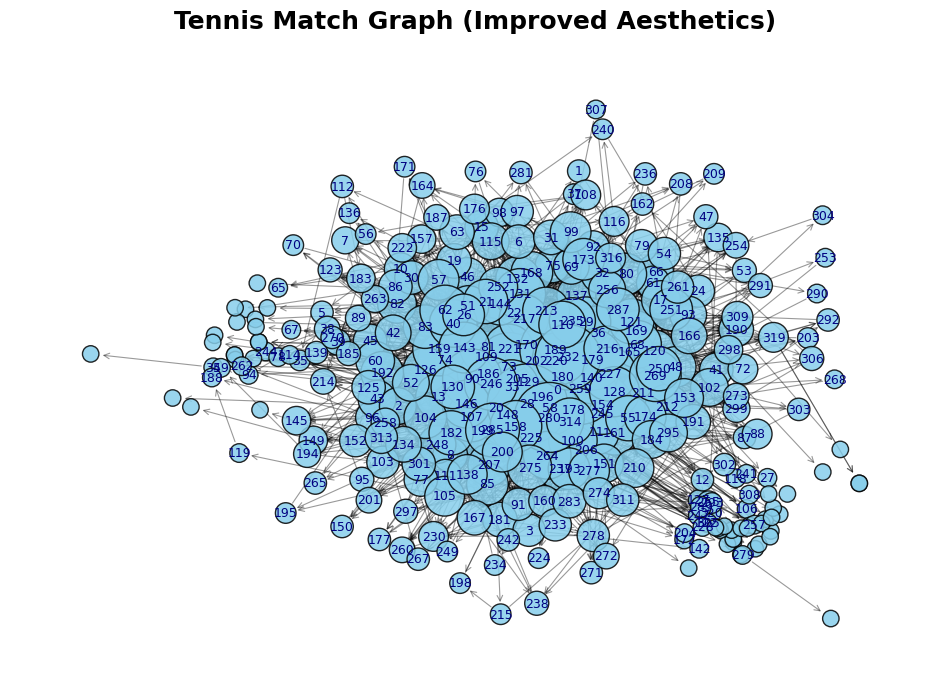

In [151]:
matches = matches_minimal[['winner_idx', 'loser_idx']]
# Create the graph from match data
G = nx.DiGraph()
edges = list(zip(matches['winner_idx'], matches['loser_idx']))
G.add_edges_from(edges)

# Draw the graph with good aesthetics
plt.figure(figsize=(12, 8))

# Use a spring layout for better separation of nodes
pos = nx.kamada_kawai_layout(G)

# Draw nodes with smoother size scaling
node_size = [100 + 40 * G.degree(n) for n in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="skyblue", alpha=0.85, edgecolors="black")

# Draw edges with better transparency and width
nx.draw_networkx_edges(G, pos, alpha=0.4, width=0.8, arrowstyle="->", arrowsize=10)

# Only label high-degree nodes to avoid clutter
high_degree_nodes = [n for n, d in G.degree() if d > 1]
labels = {n: n for n in high_degree_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color="navy")

# Add a clean title
plt.title("Tennis Match Graph (Improved Aesthetics)", fontsize=18, fontweight="bold", pad=20)

# Remove axis
plt.axis("off")
plt.show()

/Users/n.makdoud/personal/website/blog/notebooks/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


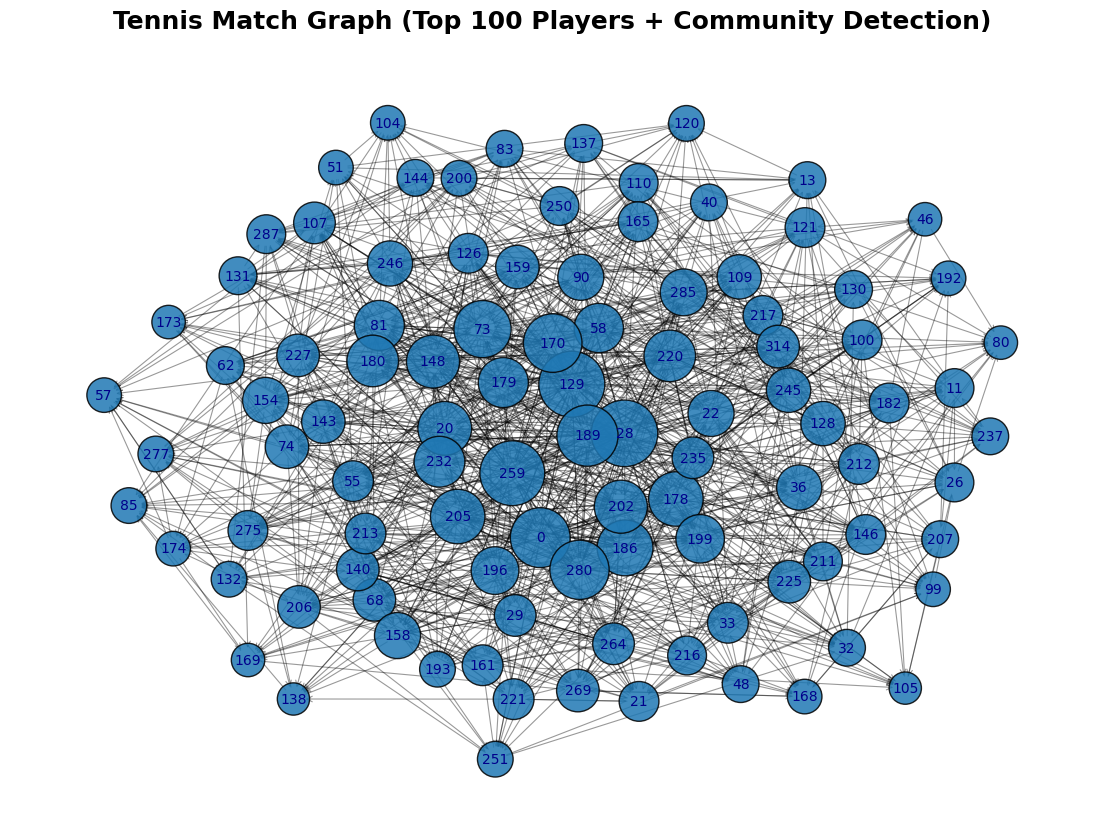

In [171]:
# Step 1: Focus on top 100 players by number of matches played
top_players = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]
top_nodes = [player[0] for player in top_players]
G_top = G.subgraph(top_nodes).copy()


# Step 3: Plot the graph with improved layout and color coding
plt.figure(figsize=(14, 10))

# Use a spring layout for better node separation
#pos = nx.spring_layout(G_top, seed=42)
pos = nx.kamada_kawai_layout(G_top)

# Assign color based on community
node_size = [100 + 40 * G_top.degree(n) for n in G_top.nodes]

# Draw nodes with color map
nx.draw_networkx_nodes(G_top, pos, node_size=node_size,
                       cmap=plt.cm.tab20, alpha=0.85, edgecolors="black")

# Draw edges with transparency
nx.draw_networkx_edges(G_top, pos, alpha=0.4, width=0.8, arrowstyle="->", arrowsize=10)

# Label only highest degree nodes for clarity
high_degree_nodes = [n for n, d in G_top.degree() if d > 5]
labels = {n: n for n in high_degree_nodes}
nx.draw_networkx_labels(G_top, pos, labels, font_size=10, font_color="darkblue")

# Clean up the plot
plt.title("Tennis Match Graph (Top 100 Players + Community Detection)", fontsize=18, fontweight="bold", pad=20)
plt.axis("off")
plt.show()


### Graph-Based Skill Estimation

We will use **Gaussian Markov Random Field (GMRF)**

A GMRF allows you to:
- Introduce graph-based dependencies between player skill estimates.
- Use inter-league and inter-player interactions to adjust skill levels consistently.
- Solve the bias introduced by isolated leagues using graph connectivity.

1. Graph Definition

Define a graph $G=(V, E)$ where:
- $V=$ set of players
- $E=$ edges between players based on match history

2. Gaussian Markov Random Field for Skill Modeling

Model the skill of player $i$ as:

$$
s_i \sim \mathcal{N}\left(\mu_0, \sigma_0^2\right)
$$

with a prior correlation based on the graph:

$$
P\left(s_i\right) \propto \exp \left(-\frac{1}{2} \sum_{(i, j) \in E} w_{i j}\left(s_i-s_j\right)^2\right)
$$

where:
- $w_{i j}=$ edge weight reflecting the strength of connection (e.g., number of matches)

This defines a GMRF where connected players' skills are encouraged to be similar, but still able to vary based on match outcomes.

3. Likelihood of Match Outcome

For match $i$ vs $j$, model the win probability using the Gaussian CDF:

$$
P(i \triangleright j)=\Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)
$$

where:
- $\Phi=$ cumulative distribution function of a standard normal
- $\beta=$ variance parameter governing outcome noise
4. Posterior Distribution

Posterior over skills given outcomes:

$$
P(s \mid y) \propto \exp \left(-\frac{1}{2} \sum_i \frac{\left(s_i-\mu_0\right)^2}{\sigma_0^2}-\frac{1}{2} \sum_{(i, j) \in E} w_{i j}\left(s_i-s_j\right)^2+\sum_{(i, j)} y_{i j} \log \Phi\left(\frac{s_i-s_j}{\sqrt{2} \beta}\right)\right)
$$


In [179]:
player_names[reverse_player_id_map[170]]

'Andrey Rublev'